# German Traffic Sign Recognition

We will develop a Convolutional Neural Network (CNN) model to recognize traffic signs using the German Traffic Sign dataset.

<img src="https://storage.googleapis.com/kaggle-datasets-images/82373/191501/4f9f4f59d288718705ff67449bbc8e66/dataset-cover.jpg?t=2018-11-25-18-48-30" alt="Dataset Cover" width="900">

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

### Import Data - EDA

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

100%|███████████████████████████████████████████████████████████████████████████████| 612M/612M [02:01<00:00, 5.29MB/s]

Extracting files...


Path to dataset files: C:\Users\OguzToy\.cache\kagglehub\datasets\meowmeowmeowmeowmeow\gtsrb-german-traffic-sign\versions\1


In [2]:
train = pd.read_csv(r"C:\Users\OguzToy\.cache\kagglehub\datasets\meowmeowmeowmeowmeow\gtsrb-german-traffic-sign\versions\1\Train.csv")

In [3]:
train

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
...,...,...,...,...,...,...,...,...
39204,52,56,5,6,47,51,42,Train/42/00042_00007_00025.png
39205,56,58,5,5,51,53,42,Train/42/00042_00007_00026.png
39206,58,62,5,6,53,57,42,Train/42/00042_00007_00027.png
39207,63,69,5,7,58,63,42,Train/42/00042_00007_00028.png


In [4]:
train.shape

(39209, 8)

In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Width,39209.0,50.835880,24.306933,25.0,35.0,43.0,58.0,243.0
Height,39209.0,50.328930,23.115423,25.0,35.0,43.0,58.0,225.0
Roi.X1,39209.0,5.999515,1.475493,0.0,5.0,6.0,6.0,20.0
Roi.Y1,39209.0,5.962381,1.385440,5.0,5.0,6.0,6.0,20.0
Roi.X2,39209.0,45.197302,23.060157,20.0,29.0,38.0,53.0,223.0
Roi.Y2,39209.0,44.728379,21.971145,20.0,30.0,38.0,52.0,205.0
ClassId,39209.0,15.788390,12.013238,0.0,5.0,12.0,25.0,42.0


In [6]:
train_img_path = r"C:\Users\OguzToy\.cache\kagglehub\datasets\meowmeowmeowmeowmeow\gtsrb-german-traffic-sign\versions\1\Train"

img_list = []
label_list = []

# Klasörler 0'dan 42'ye kadar: her biri bir sınıfı temsil ediyor
for label in os.listdir(train_img_path):
    class_dir = os.path.join(train_img_path, label)
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        img_list.append(img_path)
        label_list.append(int(label))

In [7]:
df = pd.DataFrame({'img': img_list, 'label': label_list})

In [13]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [17]:
df['label_name'] = df['label'].map(classes)

In [19]:
df.sample(10)

,img,label,label_name
4891,C:\Users\OguzToy\.cache\kagglehub\datasets\meo...,11,Right-of-way at intersection
6445,C:\Users\OguzToy\.cache\kagglehub\datasets\meo...,12,Priority road
19908,C:\Users\OguzToy\.cache\kagglehub\datasets\meo...,25,Road work
28543,C:\Users\OguzToy\.cache\kagglehub\datasets\meo...,38,Keep right
3109,C:\Users\OguzToy\.cache\kagglehub\datasets\meo...,10,No passing veh over 3.5 tons
14690,C:\Users\OguzToy\.cache\kagglehub\datasets\meo...,2,Speed limit (50km/h)
13947,C:\Users\OguzToy\.cache\kagglehub\datasets\meo...,18,General caution
17672,C:\Users\OguzToy\.cache\kagglehub\datasets\meo...,22,Bumpy road
6496,C:\Users\OguzToy\.cache\kagglehub\datasets\meo...,12,Priority road
25010,C:\Users\OguzToy\.cache\kagglehub\datasets\meo...,33,Turn right ahead


### Data Visualization

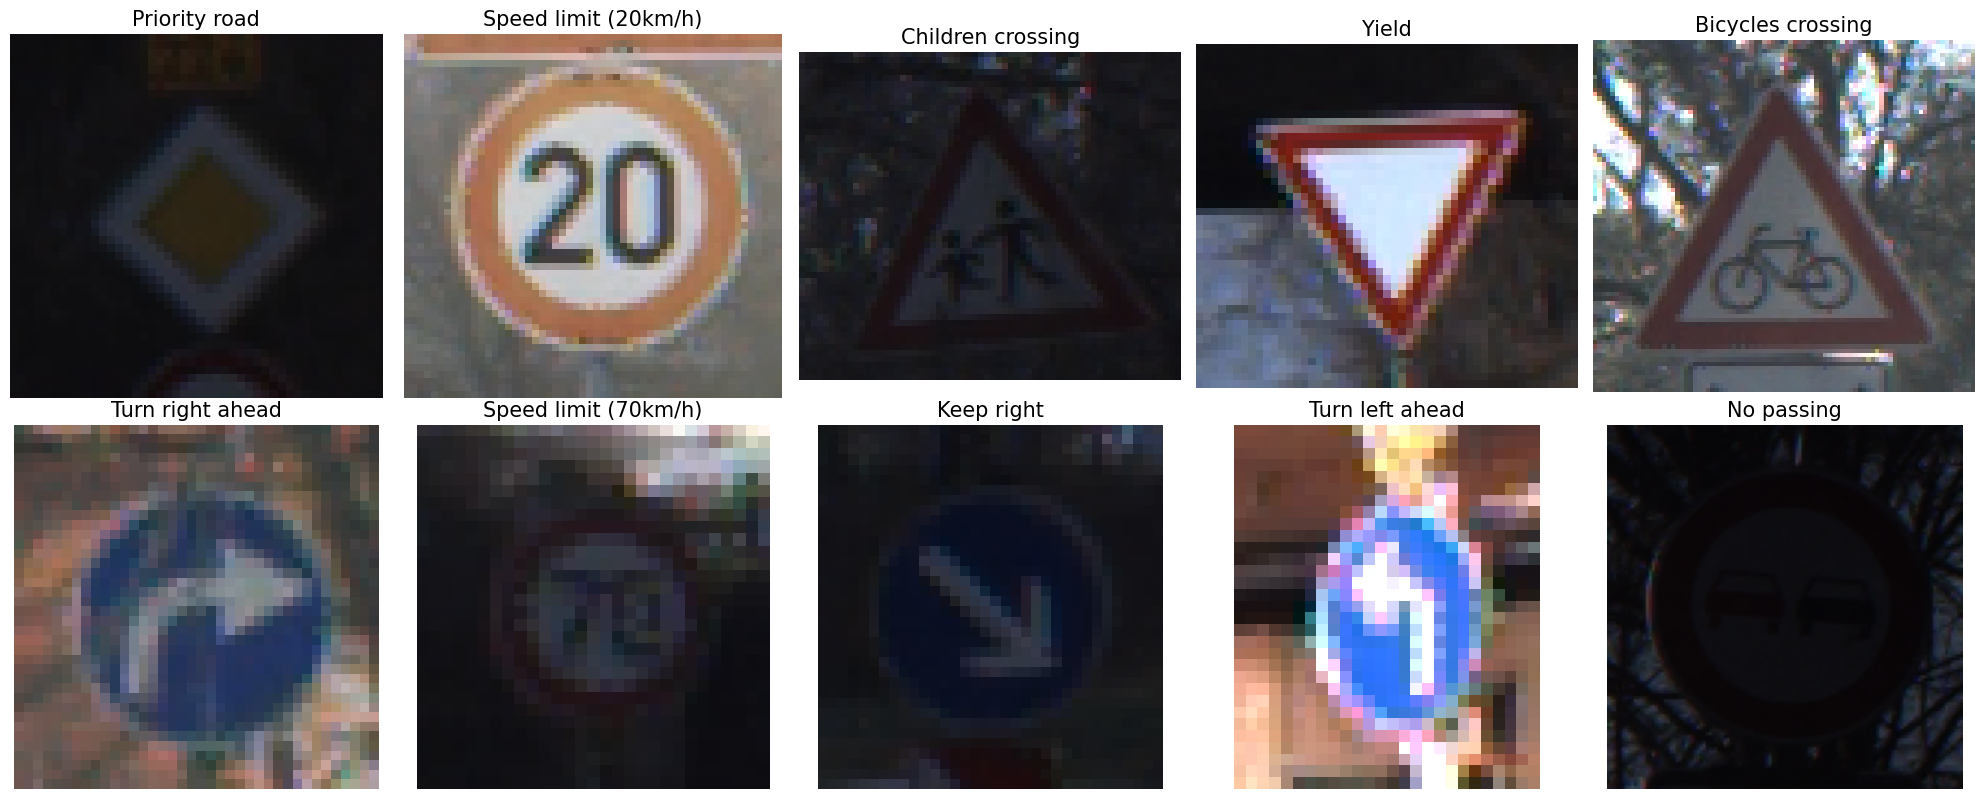

In [22]:
def show_images(df, num=10):
    sample_df = df.sample(num)
    images_per_row = 5  
    num_rows = (num - 1) // images_per_row + 1

    plt.figure(figsize=(images_per_row * 4, num_rows * 4))  

    for i, (idx, row) in enumerate(sample_df.iterrows()):
        img = cv2.imread(row['img'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(img)
        plt.title(row['label_name'], fontsize=15)  
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_images(df, num=10)

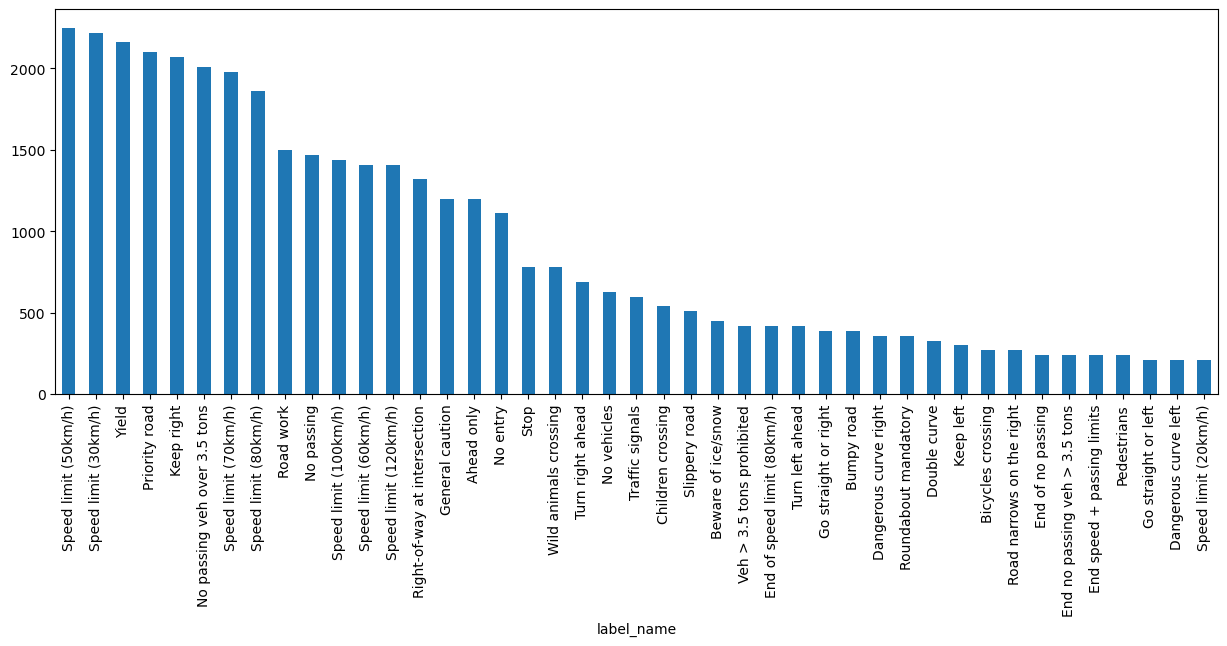

In [23]:
df['label_name'].value_counts().plot(kind='bar', figsize=(15, 5));

### Modelling

traffic sign images are read, resized to 35x35 pixels, normalized, and converted into a NumPy array for training.

In [26]:
x=[]
for img in df["img"]:
    img=cv2.imread(img)
    img=cv2.resize(img,(35,35)) # boyutunu 170*170 yaptık
    img=img/255.0 #normalize
    img=np.array(img)
    x.append(img)

In [27]:
x=np.array(x)
y=df["label"]

In [ ]:
# Train-test split

In [28]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2, random_state=8, stratify=y)

A Convolutional Neural Network (CNN) model is built and compiled with two convolutional blocks, followed by global average pooling and dense layers, and then trained using early stopping to classify traffic signs

In [29]:
model = Sequential([
    Input(shape=(35, 35, 3)),  # Input layer

    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),


    GlobalAveragePooling2D(),

    # Final Dense layer
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')  
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,              
    restore_best_weights=True
)

In [31]:
history = model.fit(
    x_train, y_train,
    batch_size=32,
    validation_data=(x_test, y_test),
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 105s 100ms/step - accuracy: 0.2174 - loss: 2.8387 - val_accuracy: 0.6659 - val_loss: 1.2932
Epoch 2/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 146s 105ms/step - accuracy: 0.7052 - loss: 0.9483 - val_accuracy: 0.8925 - val_loss: 0.3777
Epoch 3/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 105s 107ms/step - accuracy: 0.8925 - loss: 0.3590 - val_accuracy: 0.9563 - val_loss: 0.1508
Epoch 4/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 136s 101ms/step - accuracy: 0.9316 - loss: 0.2240 - val_accuracy: 0.9739 - val_loss: 0.1001
Epoch 5/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 142s 101ms/step - accuracy: 0.9522 - loss: 0.1574 - val_accuracy: 0.9753 - val_loss: 0.0857
Epoch 6/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 146s 104ms/step - accuracy: 0.9597 - loss: 0.1317 - val_accuracy: 0.9788 - val_loss: 0.0737
Epoch 7/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 98s 100ms/step - accuracy: 0.9631 - loss: 0.1260 - val_accuracy: 0.9870 - val_loss: 0.0523
Epoch 8/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 147s 105ms/step - accuracy: 0.9678 - 

In [33]:
model.save("trafic_sign_recognition.keras")

In [34]:
# Evaluating the model
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

246/246 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9981 - loss: 0.0092
Test Loss: 0.0067
Test Accuracy: 0.9986


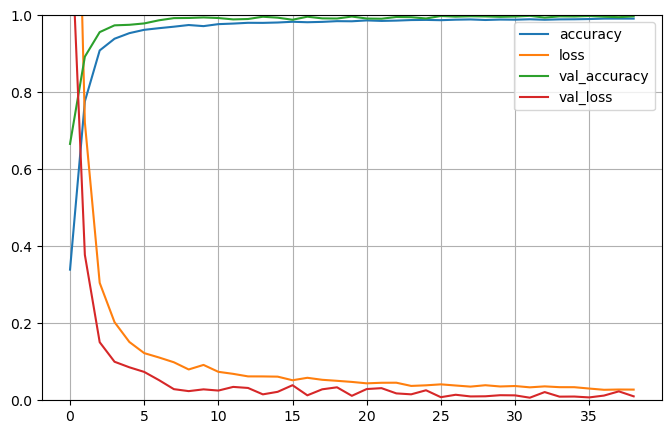

In [36]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

The model achieved high accuracy (around 99%) on both training and validation datasets, indicating successful learning. The decreasing and stabilizing loss values show that the model generalizes well without overfitting.

## model.summary()

### Prediction based on test data

In [42]:
test_img_path = r"C:\Users\OguzToy\.cache\kagglehub\datasets\meowmeowmeowmeowmeow\gtsrb-german-traffic-sign\versions\1\Test"
test_csv_path = r"C:\Users\OguzToy\.cache\kagglehub\datasets\meowmeowmeowmeowmeow\gtsrb-german-traffic-sign\versions\1\Test.csv"

In [43]:
df_test = pd.read_csv(test_csv_path)

In [44]:
df_test['img'] = df_test['Path'].apply(lambda x: os.path.join(test_img_path, x.replace('Test/', '')))

In [45]:
df_test['label'] = df_test['ClassId']

In [46]:
df_test['label_name'] = df_test['label'].map(classes)

In [47]:
df_test.sample(10)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,img,label,label_name
11511,41,40,5,5,36,35,31,Test/11511.png,C:\Users\OguzToy\.cache\kagglehub\datasets\meo...,31,Wild animals crossing
11328,69,72,6,7,63,66,36,Test/11328.png,C:\Users\OguzToy\.cache\kagglehub\datasets\meo...,36,Go straight or right
8023,42,43,5,5,37,38,9,Test/08023.png,C:\Users\OguzToy\.cache\kagglehub\datasets\meo...,9,No passing
7321,33,33,6,6,28,28,38,Test/07321.png,C:\Users\OguzToy\.cache\kagglehub\datasets\meo...,38,Keep right
9405,44,46,6,5,39,40,38,Test/09405.png,C:\Users\OguzToy\.cache\kagglehub\datasets\meo...,38,Keep right
9184,36,37,5,5,31,32,9,Test/09184.png,C:\Users\OguzToy\.cache\kagglehub\datasets\meo...,9,No passing
96,42,43,6,6,37,38,3,Test/00096.png,C:\Users\OguzToy\.cache\kagglehub\datasets\meo...,3,Speed limit (60km/h)
4463,26,26,5,5,21,21,8,Test/04463.png,C:\Users\OguzToy\.cache\kagglehub\datasets\meo...,8,Speed limit (120km/h)
1978,38,39,5,6,33,34,10,Test/01978.png,C:\Users\OguzToy\.cache\kagglehub\datasets\meo...,10,No passing veh over 3.5 tons
12428,116,122,11,10,106,112,9,Test/12428.png,C:\Users\OguzToy\.cache\kagglehub\datasets\meo...,9,No passing


In [48]:
x=[]
for img in df_test["img"]:
    img=cv2.imread(img)
    img=cv2.resize(img,(35,35)) 
    img=img/255.0 #normalize
    img=np.array(img)
    x.append(img)

In [49]:
x=np.array(x)
y=df_test["label"]
pred = model.predict(x)

395/395 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step


In [50]:
pred = np.argmax(pred, axis=1)

acc = accuracy_score(y, pred)
print("Accuracy:", acc)

Accuracy: 0.9669833729216152


In [51]:
cf = confusion_matrix(y , pred)
cf

array([[ 60,   0,   0, ...,   0,   0,   0],
       [  0, 720,   0, ...,   0,   0,   0],
       [  0,  11, 738, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  87,   0,   0],
       [  0,   0,   0, ...,   0,  57,   0],
       [  0,   0,   0, ...,   0,   0,  73]], dtype=int64)

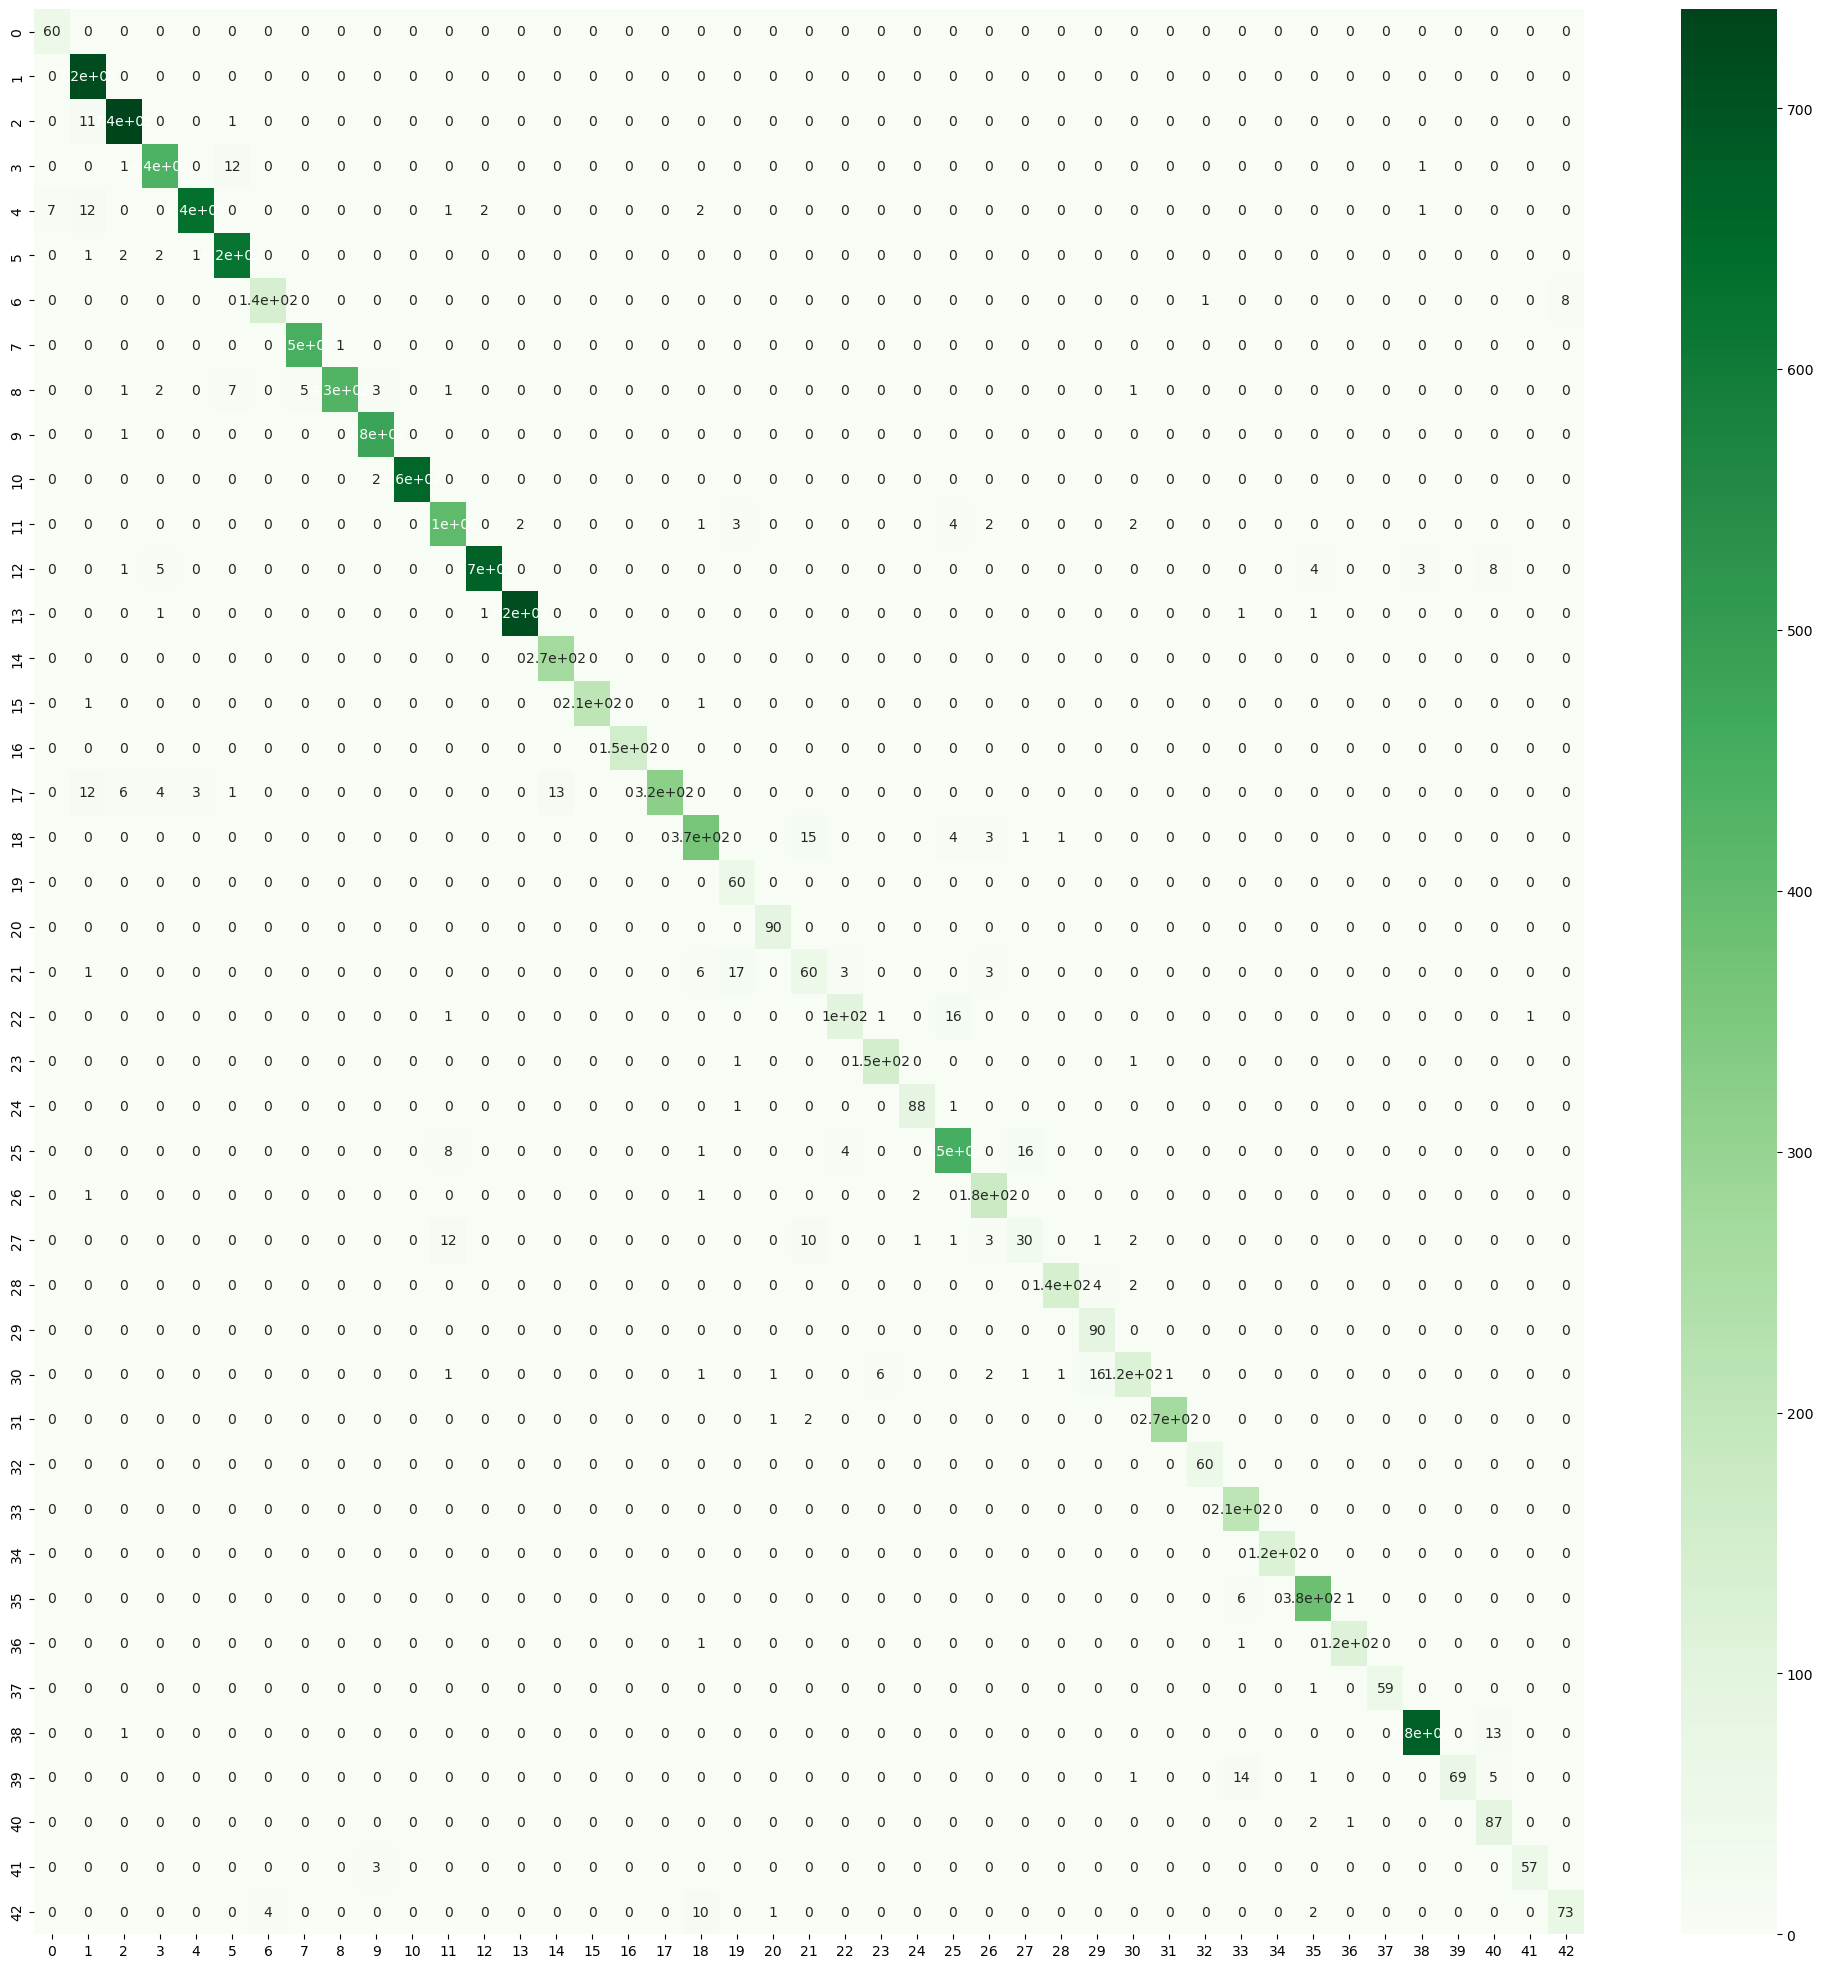

In [61]:
plt.figure(figsize = (25,25))
sns.heatmap(cf, annot=True, cmap="Greens");

In [53]:
print(classification_report(y, pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.94        60
           1       0.95      1.00      0.97       720
           2       0.98      0.98      0.98       750
           3       0.97      0.97      0.97       450
           4       0.99      0.96      0.98       660
           5       0.97      0.99      0.98       630
           6       0.97      0.94      0.96       150
           7       0.99      1.00      0.99       450
           8       1.00      0.96      0.98       450
           9       0.98      1.00      0.99       480
          10       1.00      1.00      1.00       660
          11       0.94      0.97      0.96       420
          12       1.00      0.97      0.98       690
          13       1.00      0.99      1.00       720
          14       0.95      1.00      0.98       270
          15       1.00      0.99      1.00       210
          16       1.00      1.00      1.00       150
          17       1.00    

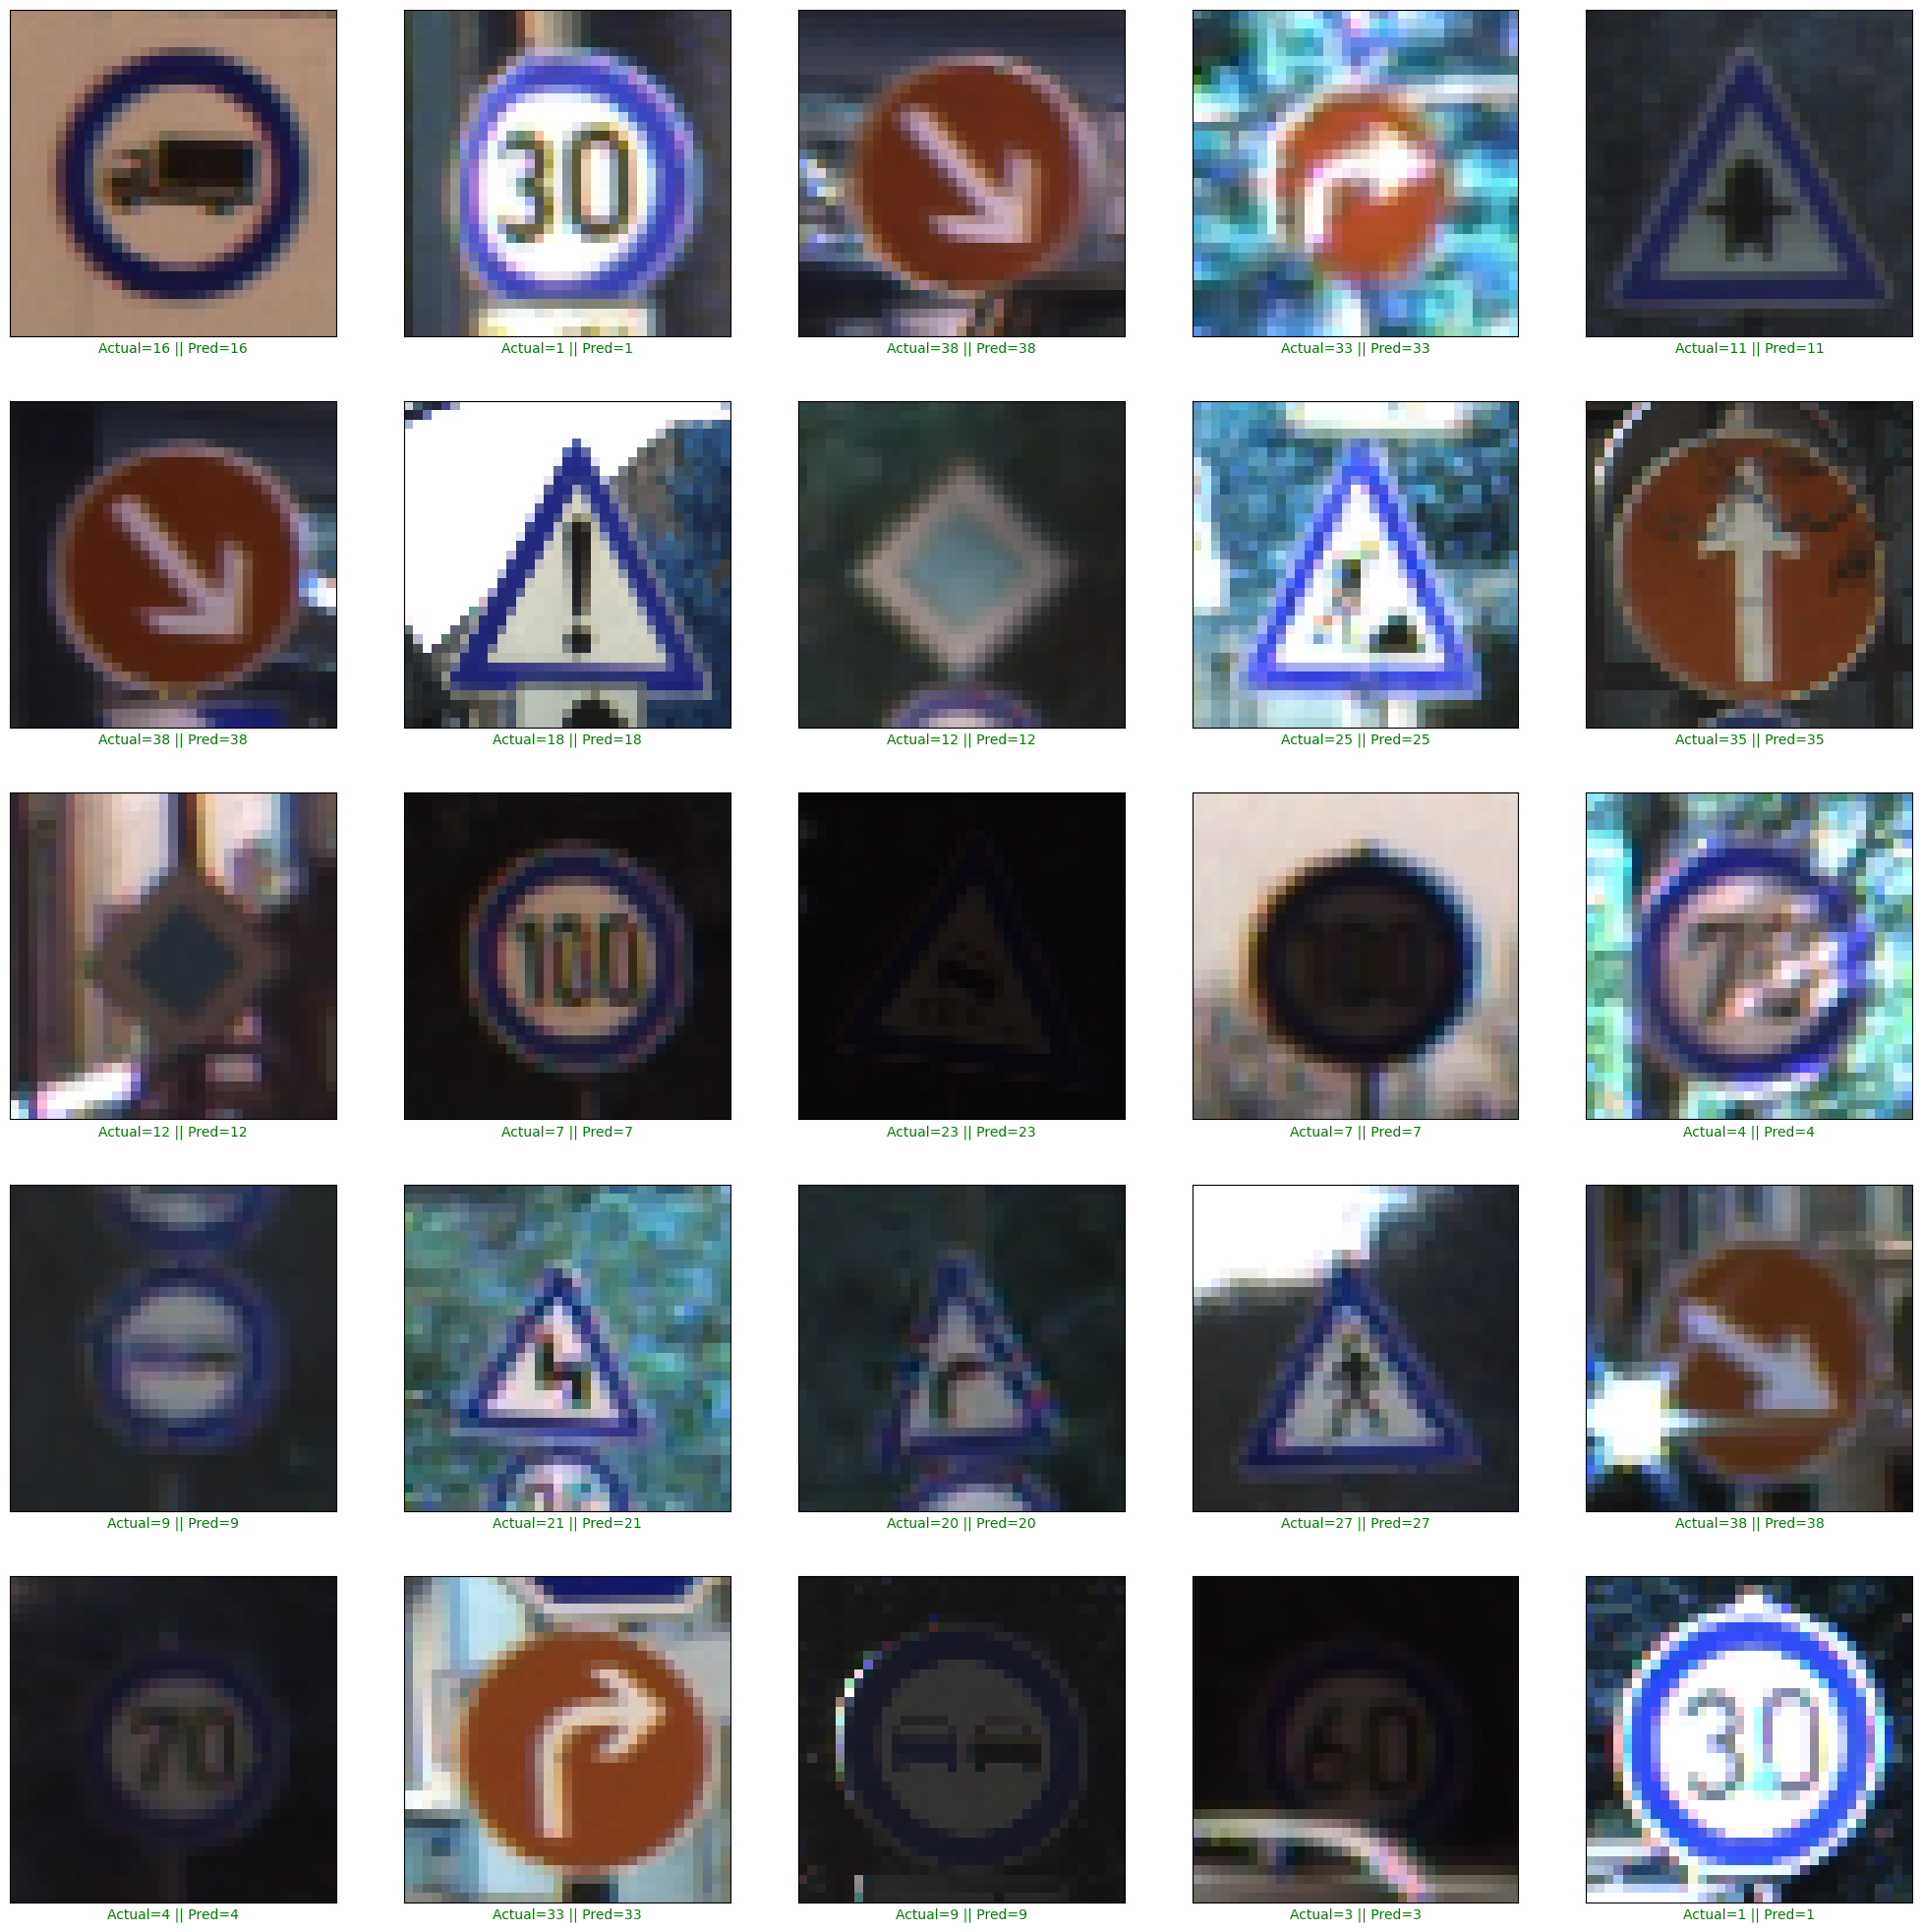

In [57]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = y[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(x[start_index + i])
plt.show()